# Sasaki metric for Bézier splines: An Application to the Statistical Analysis of Hurricane Tracks

Authors: Dr. Esfandiar Nava-Yazdani, Felix Ambellan, Martin Hanik, and Dr. Christoph von Tycowicz


This notebook accompanies the paper ''Sasaki Metric for Spline Models of Manifold-Valued Trajectories'' and allows to reproduce the described experiments. In the following, we endow the manifold of 2-segment cubic Bézier splines (the *Bézierfold*) with a novel, natural metric based on the Sasaki metric. We utilize this space to analyze atlantic hurricane tracks statistically.

In [7]:
%env JAX_PLATFORM_NAME=cpu
%matplotlib inline

import jax
import numpy as np

import matplotlib.pyplot as plt
from util import visEarth, colors, legend_handle, sample_spline

from morphomatics.manifold import Sphere, CubicBezierfold

env: JAX_PLATFORM_NAME=cpu


We start by importing the data on the tracks of the 2010-2021 hurricanes that was obtained from the [HURDAT 2](https://www.nhc.noaa.gov/data/) database.

In [8]:
data = np.load('datasets/hur.npz', allow_pickle=True)
subj, seq, ids, info = data['subj'], data['seq'], data['ids'], data['info']

n_subj = len(subj)
# yearly_samples = np.array([int(a[-1]) for a in subj])

print(f"Number of subjects: {n_subj}, Total number of observations: {ids[n_subj]}")

Number of subjects: 218, Total number of observations: 6641


The following code regresses a 2-segment, cubic Bézier spline to each of the . The computation takes several minutes. The (control points of the) resulting splines are already saved in the ''datasets'' folder; the cell is thus commented and can be skipped to save time.

In [9]:
# import jax.numpy as jnp
# from morphomatics.stats import RiemannianRegression
# from util import get_subj_year
#
# years = get_subj_year(subj)
#
# # instantiate manifolds
# S2 = Sphere()
# BfS2 = CubicBezierfold(S2, 2)
#
# # regression
#
# points, categories = seq[:, 7:10], seq[:, 5]  # 7-9 are cartesian coordinates
# num_years = len(years)
# p, u = np.zeros((num_years, 3)), np.zeros((num_years, 3))
# t = jnp.linspace(0., 1., 25)
# ctrl_pts = []
# r2_values = []
# for j in range(num_years-1):
#     print(f'year : {2010 + j}')
#     geos, trjs = [], []
#     for i in range(years[j], years[j+1]):
#         len_trj = subj[i, 2]
#         x, trj = jnp.linspace(0., 2., len_trj), points[ids[i]:ids[i] + len_trj]
#         vel = categories[ids[i]:ids[i] + len_trj]
#
#         reg = RiemannianRegression(S2, jnp.array(trj), x, 3, 2)
#
#         ctrl_pts.append(np.array(BfS2.to_coords(reg.trend)))
#         r2_values.append(reg.R2statistic)
#         geos.append(reg.trend)
#         trjs.append(trj)
#
# np.save('datasets/R2_2_segment_splines', np.array(r2_values))
# np.save('datasets/2_segment_splines', ctrl_pts)

First comes loading the (pre-)computed splines.

In [10]:
ctrl_pts = np.load('./datasets/2_segment_splines.npy')

The wind speed determines how dangerous a hurricane is. We extract for each track in the database the [*maximum sustained wind*](https://en.wikipedia.org/wiki/Maximum_sustained_wind) and plot the frequencies. The [*Saffir–Simpson scale*](https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale) uses the 1-minute maximum sustained winds to categorize tropical storms from 0 to 5 (5 potentially being the most dangerous storms).

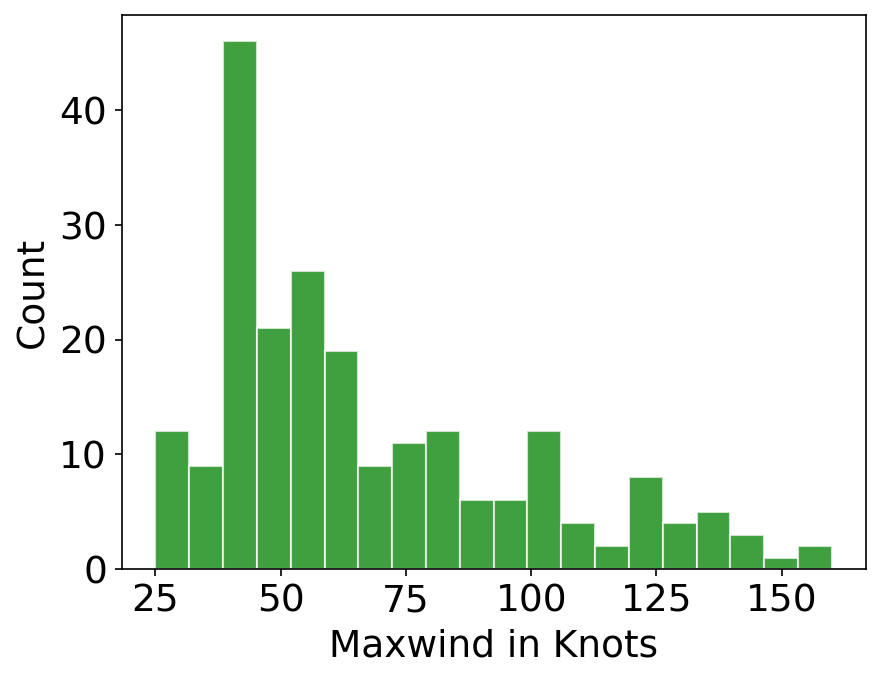

In [11]:
yearly_samples = np.array([int(a[-1]) for a in subj])
rep_ids = np.repeat(np.arange(len(yearly_samples)), yearly_samples)

maxwind = jax.ops.segment_max(seq[:, 5], rep_ids, indices_are_sorted=True)

plt.figure(dpi=150)
plt.rc('font', size=18)
plt.hist(np.asarray(maxwind), 20, density=False, facecolor='g', edgecolor="w", alpha=0.75)
plt.xlabel('Maxwind in Knots')
plt.ylabel('Count')
plt.show()

To assess how well the tracks are represented by the splines, we plot a histogram of their $R^2$-values. The maximal value is 1, indicating a perfect fit.

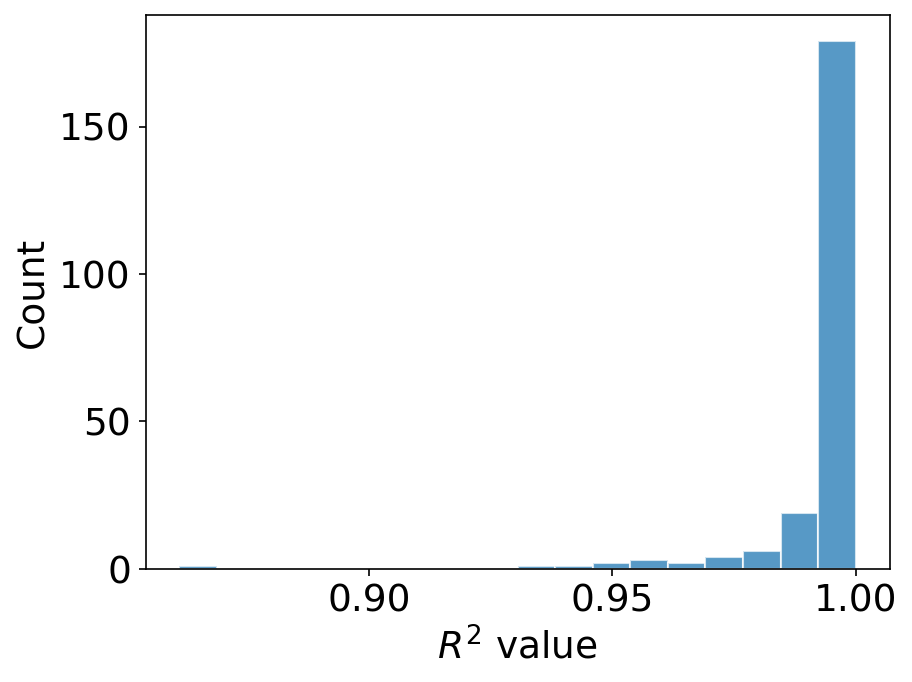

In [12]:
plt.figure(dpi=150)
plt.rc('font', size=18)
x = np.load('datasets/R2_2_segment_splines.npy')
_ = plt.hist(x, 18, density=False, edgecolor="w", alpha=0.75)

plt.xlabel('$R^2$ value')
plt.ylabel('Count')


plt.show()

We can also plot the original trend and the corresponding spline for all hurricanes.

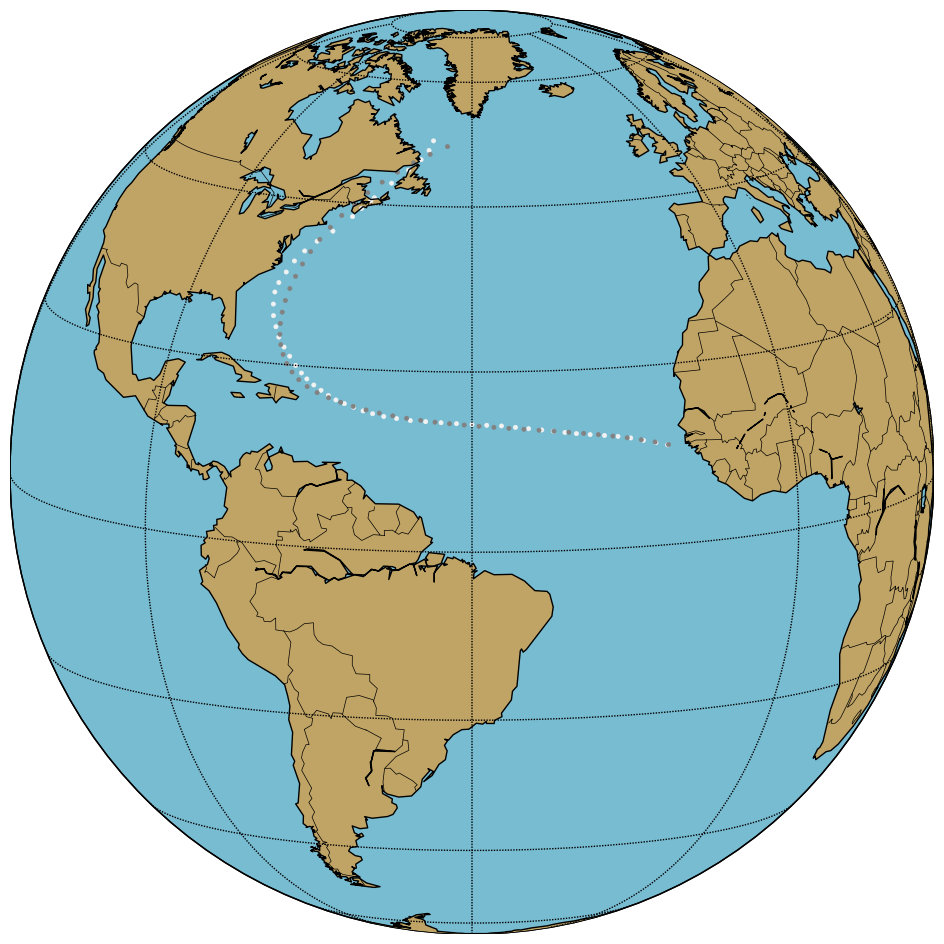

In [13]:
from matplotlib import cm

# instantiate manifolds again (the cell above might not have been run)
S2 = Sphere()
BfS2 = CubicBezierfold(S2, 2)

def visualize_tracks(index):
    # spline approximations
    s_id = BfS2.from_coords(ctrl_pts[index])
    seq_spline = [sample_spline(s_id)]

    # original data
    seq_orig = [seq[ids[index]:ids[index] + subj[index, 2], 3:5]]

    cmap_cat_gray = cm.get_cmap('gray')
    visEarth([seq_orig, seq_spline], [[130], [70]], title=None, c_map=cmap_cat_gray)

visualize_tracks(6)  # replace by indices between 0 and 217 to see other hurricanes

We want to use the tracks of the hurricanes for 3-class intensity classification: Hurricanes with maximum sustained wind slower than 64 knots (category 0), between 64 and 112 knots (categories 1 to 3), and faster than 112 knots (categories 4 and 5) are labeled as classes 0, 1, and 2, respectively.

In [14]:
# category label for classification
y = np.array([0 if w < 64 else (1 if w < 113 else 2) for w in maxwind])
print(f'There are {np.bincount(y)[0]} with label 0, {np.bincount(y)[1]} with label 1, and {np.bincount(y)[2]} with label 2.')

There are 124 with label 0, 69 with label 1, and 25 with label 2.


Now, we can perform a [*principal geodesic analysis*](https://en.wikipedia.org/wiki/Principal_geodesic_analysis) of the spline data in the underlying Bézierfold, and make a loading plot of the first two principal geodesic modes (i.e., the coefficients w.r.t. first and second mode). For each of the 3 classes, we also plot the (Euclidean) means of the scores in the loading plot. (When re-running, the figure can change slightly as modes are only determined up to sign.) Clearly, the mean of corresponding to the hurricanes of category 4 and 5 is well-seperated from the other two.

computing PGA took 34.174356 seconds


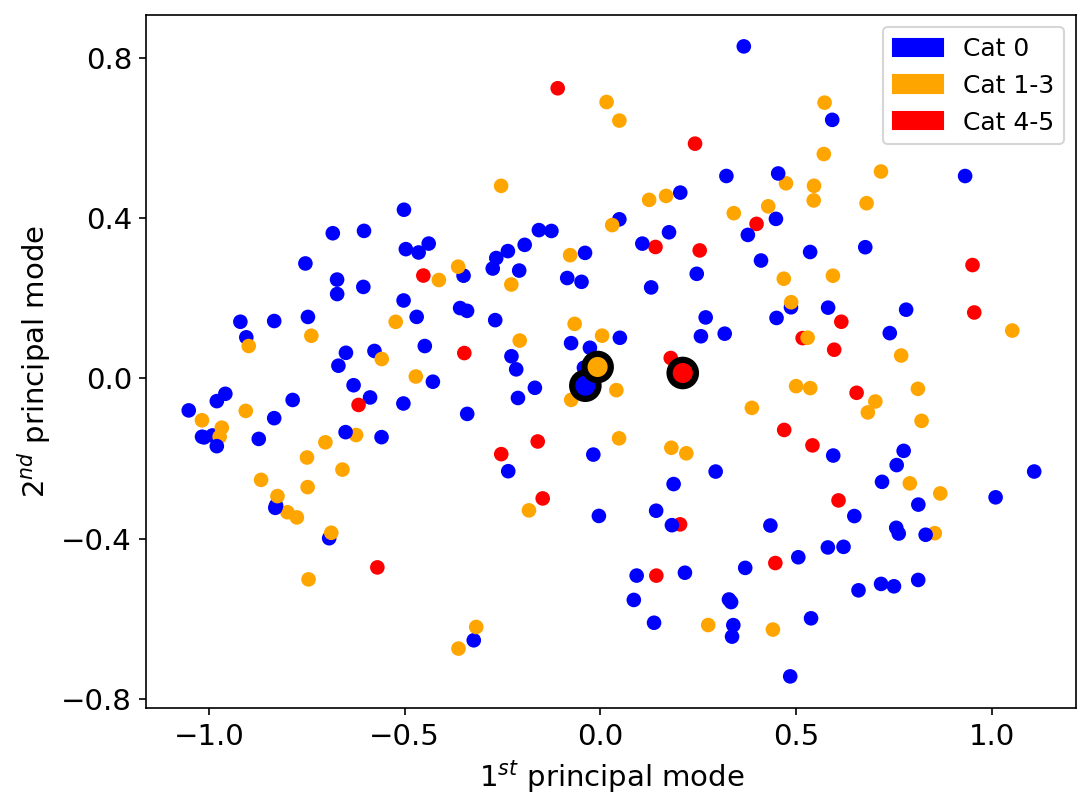

In [15]:
from morphomatics.stats import PrincipalGeodesicAnalysis
import time

t = time.perf_counter()

# principal geodesic analysis
pga = PrincipalGeodesicAnalysis(BfS2, ctrl_pts)

print('computing PGA took %f seconds' % (time.perf_counter()-t))

lbl = np.array([colors[y[i]] for i in range(len(y))])
x = pga.coeffs
cen_0 = np.mean(x[np.where(y==0)[0]], axis=0)
cen_1 = np.mean(x[np.where(y==1)[0]], axis=0)
cen_2 = np.mean(x[np.where(y==2)[0]], axis=0)
centroids = np.array([cen_0, cen_1, cen_2])

plt.figure(dpi=150, figsize=(8,6))
ax = plt.subplot(111)
plt.rc('font', size=12)
plt.rc('axes', labelsize=16)
plt.scatter(*x.T[:2], c=lbl, cmap=cm.get_cmap('jet'))
lc = np.array([colors[i] for i in range(len(centroids))])
plt.scatter(*centroids.T[:2], c=lc, edgecolor='k', s=160, linewidths=3, cmap=cm.get_cmap('jet'))
plt.legend(handles=legend_handle)
ax.set(xlabel='$1^{st}$ principal mode', ylabel='$2^{nd}$ principal mode')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.autoscale()
plt.show()

We can also visualize the PGA modes.

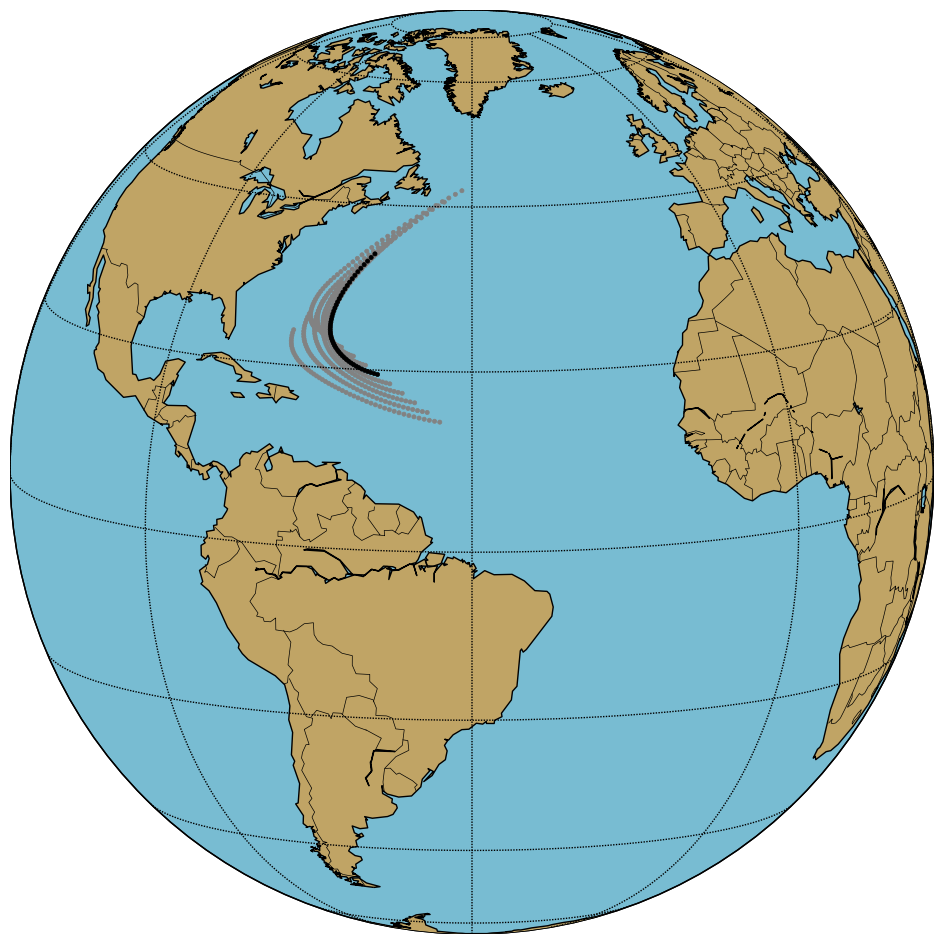

In [23]:
mean = pga.mean
std = np.sqrt(pga.variances[:])

def visualize_mode(m):
    # i-th mode at index i-1
    m -= 1
    #   evaluate mode at several points
    def eval_mode(val, m):
        modeval = BfS2.connec.exp(mean, val * std[m] * pga.modes[m])
        modeval_ = BfS2.from_coords(modeval)
        return sample_spline(modeval_)

    geo_list = []
    geo_mean_tmp = []

    n_points = 11
    vals = np.linspace(-1.5, 1.5, n_points)

    for i, v in enumerate(vals):
        if i==(len(vals)-1)/2:
            geo_mean_tmp = eval_mode(v, m)
        else:
            geo_list.append([eval_mode(v, m)])

    # print mean at last
    geo_list.append([geo_mean_tmp])

    cmap_cat_gray = cm.get_cmap('gray')
    visEarth(geo_list, [[70],]*(n_points-1) + [[0]], title=None, c_map=cmap_cat_gray)

visualize_mode(2)  # change input to visualize different modes (ordered in decreasing importance)

Finally, we come to the classification experiment. We use sklearn's support vector classification and perform 3-fold cross validation.

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score as bas

# k-fold stratified cross-validation
k_fold = 3
skf = StratifiedKFold(k_fold, shuffle=True)

# features
x = pga.coeffs

# SVM
acc = []
for n in range(1000):
    for train_index, test_index in skf.split(x, y):
        # train classifier
        svc = SVC(kernel='rbf', gamma=.7, C=3, class_weight='balanced')
        svc.fit(x[train_index], y[train_index])
        # test
        train_acc, test_acc = bas(y[train_index], svc.predict(x[train_index])), bas(y[test_index], svc.predict(x[test_index]))
        acc += [test_acc] # / k_fold # skf.get_n_splits()

acc = np.array(acc)
print('Average Test Accuracy: {:.5f}({:.5f})'.format(acc.mean(), acc.std()))


Average Test Acc: 0.61392(0.06167)
